# Learning Stable Control-oriented Deep Koopman Operators  


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of nonautonomous nonlinear dynamical systems in NeuroMANCER. 


## Koopman System Identification with Control Problem Setup

<img src="../figs/Koopman_model.png" width="500">  


System observables  $y_{k}$ and control inputs $u_k$ are encoded via encoder neural networks $f_y$ and $f_u$ to generate latent states $x_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ to obtain latent states at the next time step $x_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{x_1, ..., x_N \}$ are proejcted back to the observable space via decoder neural network $f_y^{-1}$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman with Control References

[1] [H. Shi and M. Q. . -H. Meng, "Deep Koopman Operator With Control for Nonlinear Systems," in IEEE Robotics and Automation Letters, vol. 7, no. 3, pp. 7700-7707, July 2022, doi: 10.1109/LRA.2022.3184036.](https://ieeexplore.ieee.org/document/9799788)  
[2] [Eurika Kaiser and J Nathan Kutz and Steven L Brunton, Data-driven discovery of Koopman eigenfunctions for control, Mach. Learn.: Sci. Technol. 2021](https://iopscience.iop.org/article/10.1088/2632-2153/abf0f5)  
[3] [M. Korda and I. Mezić, "Optimal Construction of Koopman Eigenfunctions for Prediction and Control," in IEEE Transactions on Automatic Control, vol. 65, no. 12, pp. 5114-5129, Dec. 2020](https://ieeexplore.ieee.org/document/9022864)  
[4] [Yiqiang Han, Wenjian Hao, Umesh Vaidya, Deep Learning of Koopman Representation for Control, 2020
](https://arxiv.org/abs/2010.07546)  
[6] [Minghao Han, Jacob Euler-Rolle, Robert K. Katzschmann, DeSKO: Stability-Assured Robust Control with a Deep Stochastic Koopman Operator, ICLR 2022](https://openreview.net/forum?id=hniLRD_XCA)  
[6] https://github.com/HaojieSHI98/DeepKoopmanWithControl


### Generic Stable Layers References
[7]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[8] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[9] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [1]:
import torch
import torch.nn as nn
import numpy as np

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

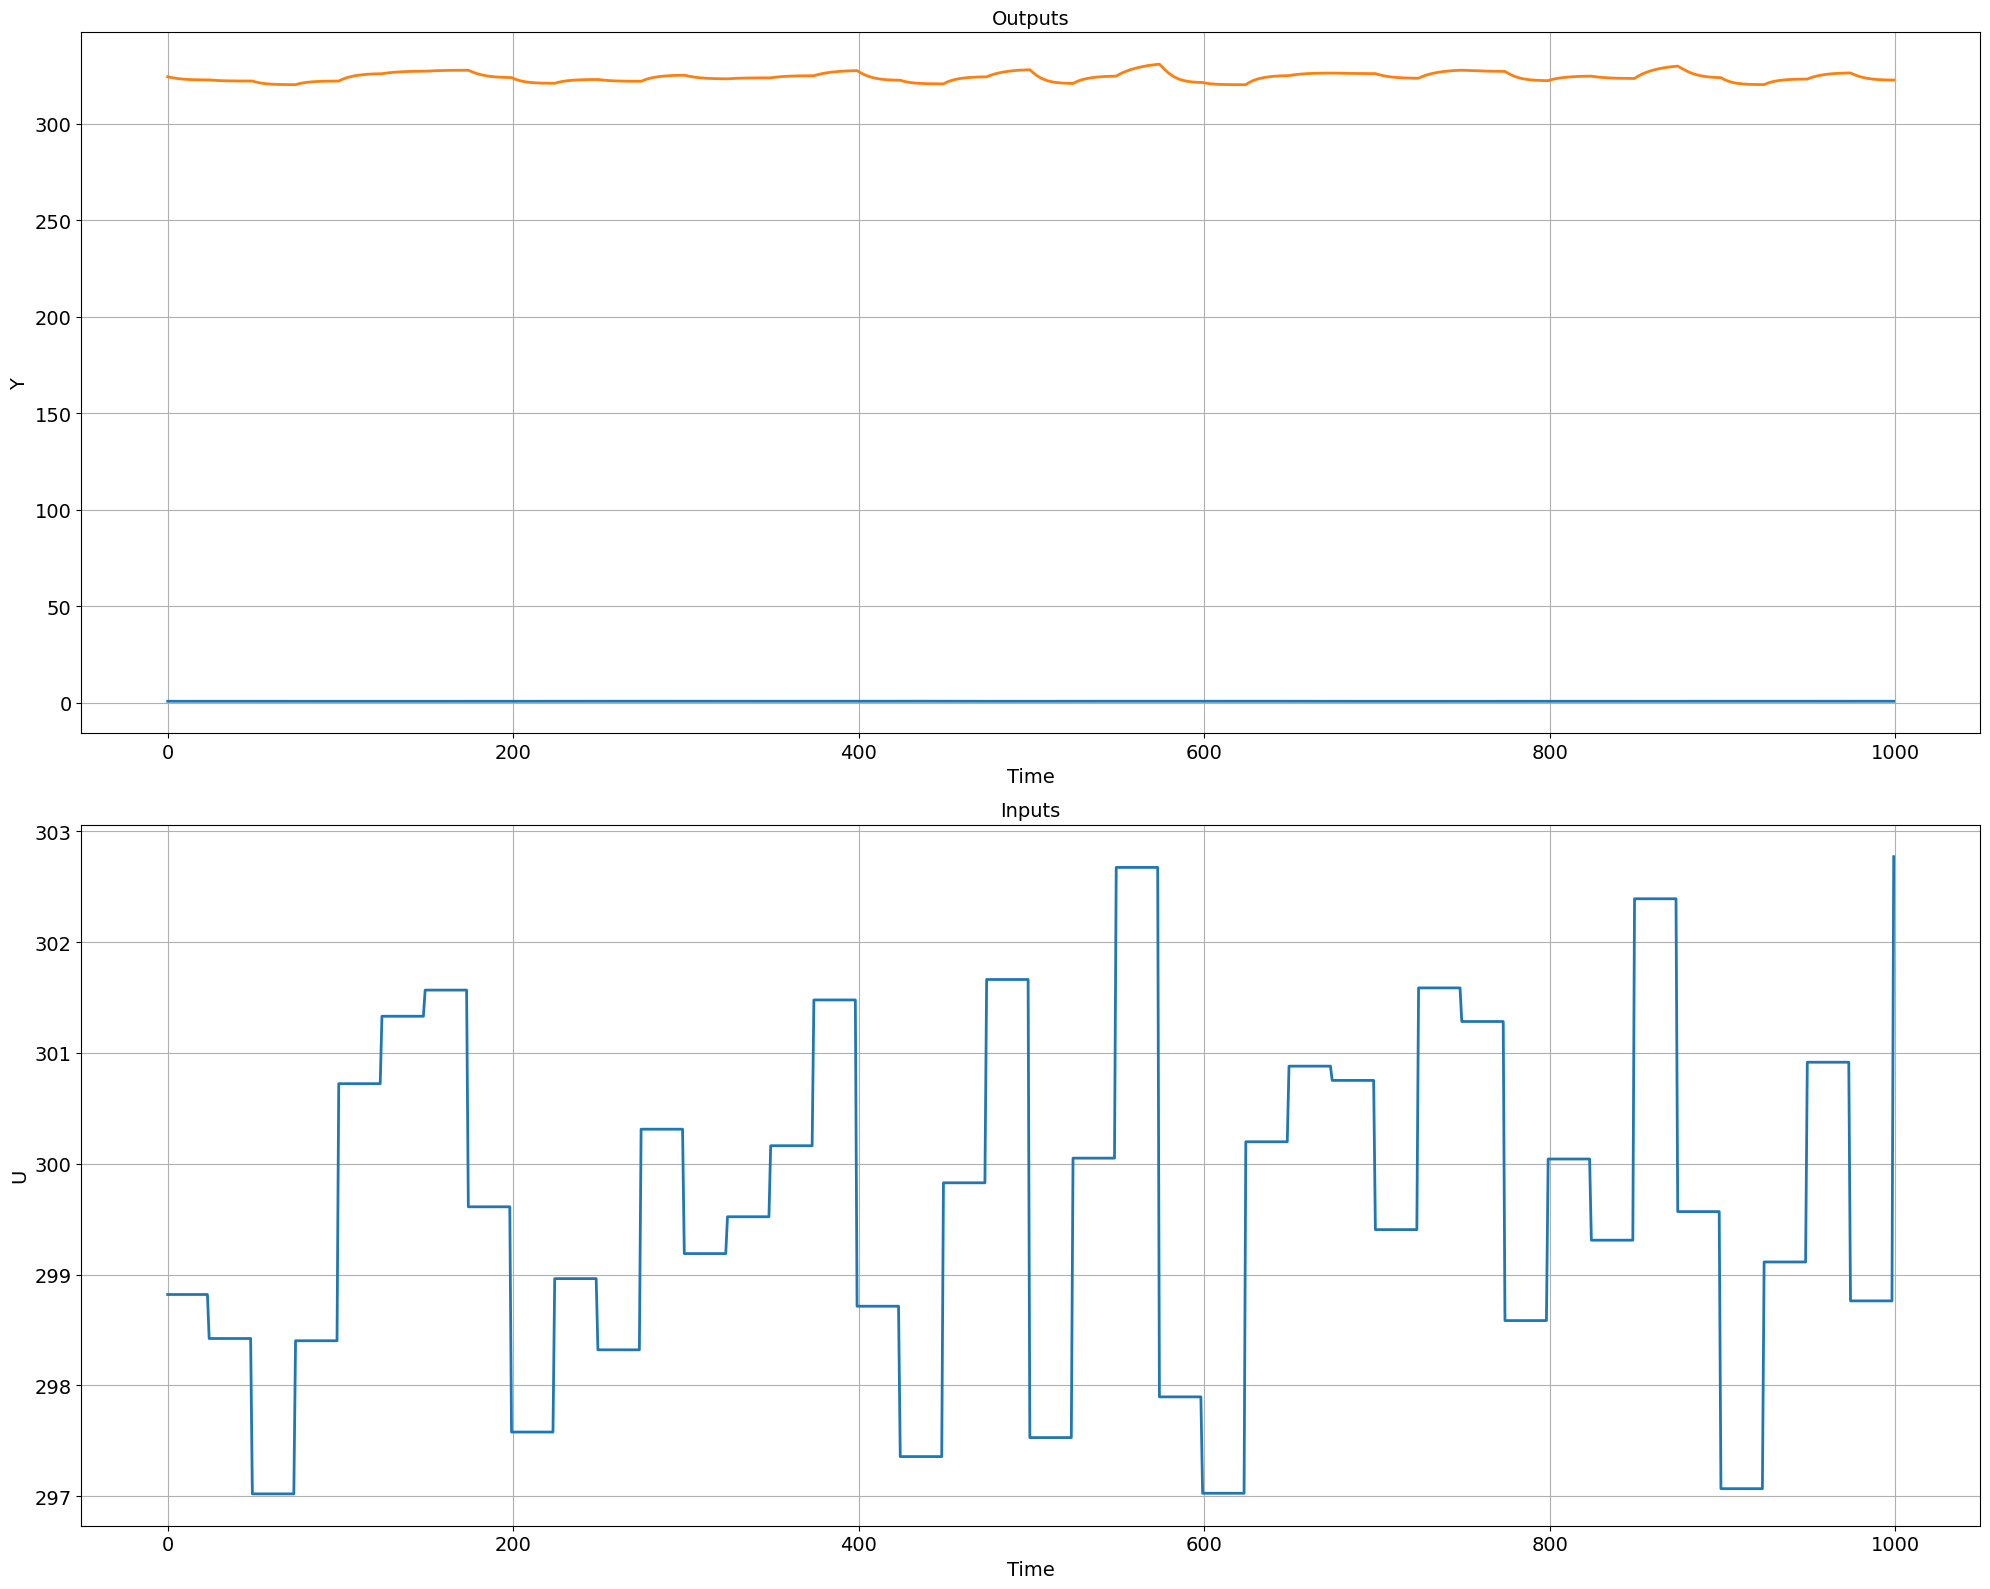

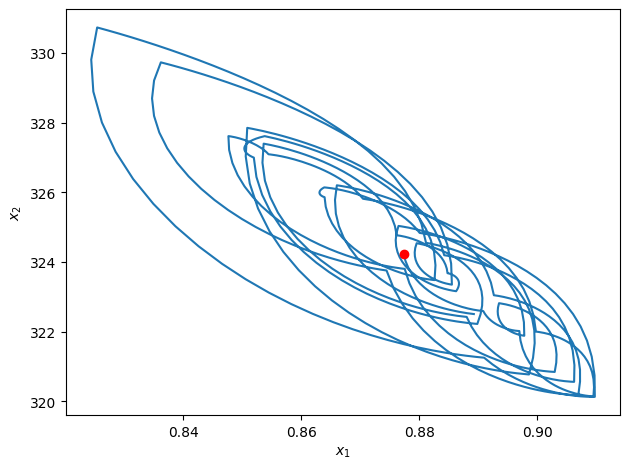

In [2]:
# %%  ground truth system
system = psl.systems['CSTR']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])


## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

In [3]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = modelSystem.stats['Y']['mean']
    std_x = modelSystem.stats['Y']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    def normalize(x, mean, std):
        return (x - mean) / std

    trainX = normalize(train_sim['Y'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['Y'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['Y'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data

In [4]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [5]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

**Encoder and Decoder networks** 

In [6]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [7]:
# instantiate input encoder net f_u
f_u = blocks.MLP(nu, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [8]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [9]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [10]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [11]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [12]:
# dynamics_model.show()

In [13]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [14]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [15]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [16]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [17]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [18]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 10.39214038848877
epoch: 1  train_loss: 9.65684986114502
epoch: 2  train_loss: 9.025233268737793
epoch: 3  train_loss: 8.42192554473877
epoch: 4  train_loss: 7.804461479187012
epoch: 5  train_loss: 7.1523118019104
epoch: 6  train_loss: 6.4631733894348145
epoch: 7  train_loss: 5.759016513824463
epoch: 8  train_loss: 5.092775821685791
epoch: 9  train_loss: 4.553518772125244
epoch: 10  train_loss: 4.262581825256348
epoch: 11  train_loss: 4.319953441619873
epoch: 12  train_loss: 4.639954566955566
epoch: 13  train_loss: 4.877208709716797
epoch: 14  train_loss: 4.816780090332031
epoch: 15  train_loss: 4.54799747467041
epoch: 16  train_loss: 4.243759632110596
epoch: 17  train_loss: 4.016694068908691
epoch: 18  train_loss: 3.8957531452178955
epoch: 19  train_loss: 3.853855609893799
epoch: 20  train_loss: 3.8460326194763184
epoch: 21  train_loss: 3.832629919052124
epoch: 22  train_loss: 3.787280321121216
epoch: 23  train_loss: 3.6965441703796387
epoch: 24  train_loss: 3.55

epoch: 195  train_loss: 0.030850136652588844
epoch: 196  train_loss: 0.030383670702576637
epoch: 197  train_loss: 0.029831409454345703
epoch: 198  train_loss: 0.029569024220108986
epoch: 199  train_loss: 0.02928011678159237
epoch: 200  train_loss: 0.028895065188407898
epoch: 201  train_loss: 0.02842484973371029
epoch: 202  train_loss: 0.027943555265665054
epoch: 203  train_loss: 0.027691621333360672
epoch: 204  train_loss: 0.027367739006876945
epoch: 205  train_loss: 0.027148915454745293
epoch: 206  train_loss: 0.027360206469893456
epoch: 207  train_loss: 0.02904723770916462
epoch: 208  train_loss: 0.03632418066263199
epoch: 209  train_loss: 0.06118280813097954
epoch: 210  train_loss: 0.09377213567495346
epoch: 211  train_loss: 0.0843663439154625
epoch: 212  train_loss: 0.028486743569374084
epoch: 213  train_loss: 0.061777178198099136
epoch: 214  train_loss: 0.06975509971380234
epoch: 215  train_loss: 0.025801781564950943
epoch: 216  train_loss: 0.061115436255931854
epoch: 217  train_l

epoch: 381  train_loss: 0.016723796725273132
epoch: 382  train_loss: 0.015602020546793938
epoch: 383  train_loss: 0.015153476037085056
epoch: 384  train_loss: 0.015761159360408783
epoch: 385  train_loss: 0.01461618859320879
epoch: 386  train_loss: 0.015171894803643227
epoch: 387  train_loss: 0.014528113417327404
epoch: 388  train_loss: 0.014540065079927444
epoch: 389  train_loss: 0.014511361718177795
epoch: 390  train_loss: 0.01419011875987053
epoch: 391  train_loss: 0.014388766139745712
epoch: 392  train_loss: 0.013836442492902279
epoch: 393  train_loss: 0.014315596781671047
epoch: 394  train_loss: 0.014004329219460487
epoch: 395  train_loss: 0.013485940173268318
epoch: 396  train_loss: 0.014152709394693375
epoch: 397  train_loss: 0.01358872465789318
epoch: 398  train_loss: 0.013740288093686104
epoch: 399  train_loss: 0.013742913492023945
epoch: 400  train_loss: 0.013080473057925701
epoch: 401  train_loss: 0.013543122448027134
epoch: 402  train_loss: 0.013230154290795326
epoch: 403  t

epoch: 570  train_loss: 0.009762760251760483
epoch: 571  train_loss: 0.009631049819290638
epoch: 572  train_loss: 0.009785452857613564
epoch: 573  train_loss: 0.009833712130784988
epoch: 574  train_loss: 0.009752528741955757
epoch: 575  train_loss: 0.009579291567206383
epoch: 576  train_loss: 0.009760829620063305
epoch: 577  train_loss: 0.009867613203823566
epoch: 578  train_loss: 0.00982919242233038
epoch: 579  train_loss: 0.009787460789084435
epoch: 580  train_loss: 0.009763973765075207
epoch: 581  train_loss: 0.010018598288297653
epoch: 582  train_loss: 0.010294254869222641
epoch: 583  train_loss: 0.010899624787271023
epoch: 584  train_loss: 0.011954933404922485
epoch: 585  train_loss: 0.014093810692429543
epoch: 586  train_loss: 0.017070451751351357
epoch: 587  train_loss: 0.023882240056991577
epoch: 588  train_loss: 0.029829464852809906
epoch: 589  train_loss: 0.04216616973280907
epoch: 590  train_loss: 0.03987283632159233
epoch: 591  train_loss: 0.03763565793633461
epoch: 592  tr

epoch: 753  train_loss: 0.010937615297734737
epoch: 754  train_loss: 0.012442909181118011
epoch: 755  train_loss: 0.015583413653075695
epoch: 756  train_loss: 0.01901271753013134
epoch: 757  train_loss: 0.02643727883696556
epoch: 758  train_loss: 0.029445888474583626
epoch: 759  train_loss: 0.036828309297561646
epoch: 760  train_loss: 0.029731642454862595
epoch: 761  train_loss: 0.02379612810909748
epoch: 762  train_loss: 0.012802894227206707
epoch: 763  train_loss: 0.00802020076662302
epoch: 764  train_loss: 0.010272225365042686
epoch: 765  train_loss: 0.015172257088124752
epoch: 766  train_loss: 0.01882411725819111
epoch: 767  train_loss: 0.014922095462679863
epoch: 768  train_loss: 0.010084914043545723
epoch: 769  train_loss: 0.008178597316145897
epoch: 770  train_loss: 0.010589701123535633
epoch: 771  train_loss: 0.01346899475902319
epoch: 772  train_loss: 0.01198156364262104
epoch: 773  train_loss: 0.009206398390233517
epoch: 774  train_loss: 0.008330751210451126
epoch: 775  train

<All keys matched successfully>

## System Identification results

In [19]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [20]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T

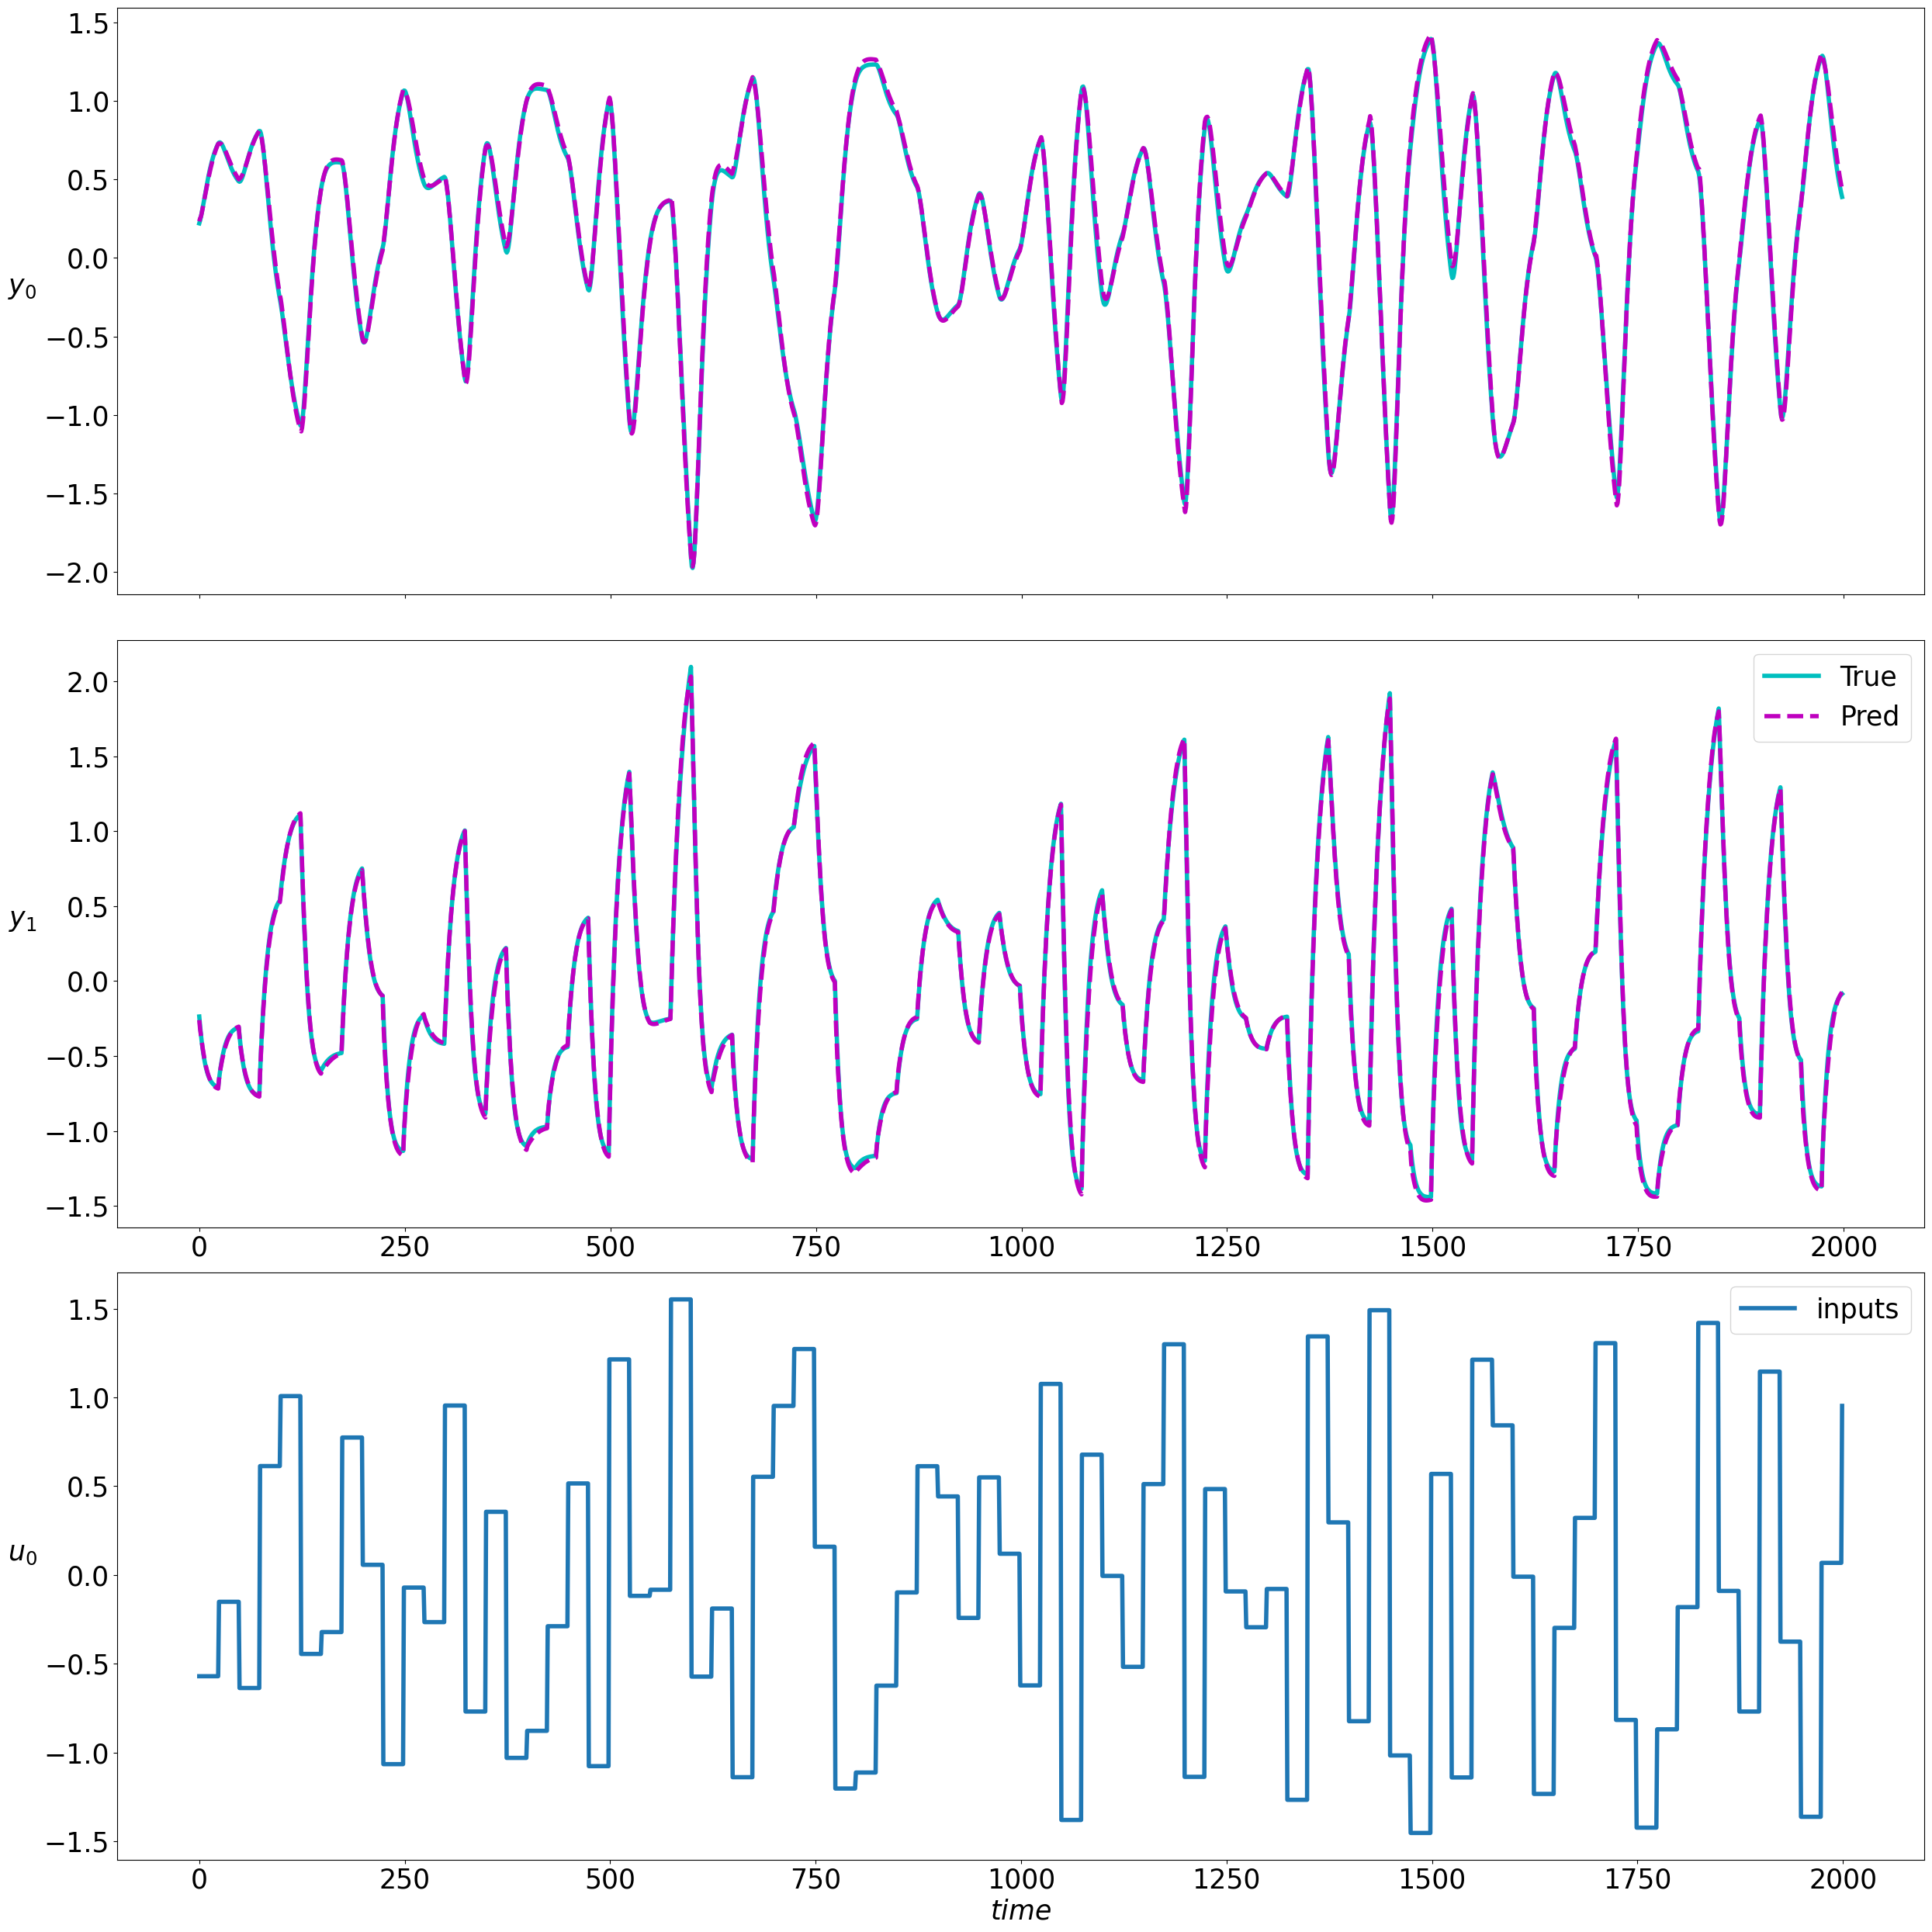

In [21]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row+nx]
    axe.plot(u, linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [22]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

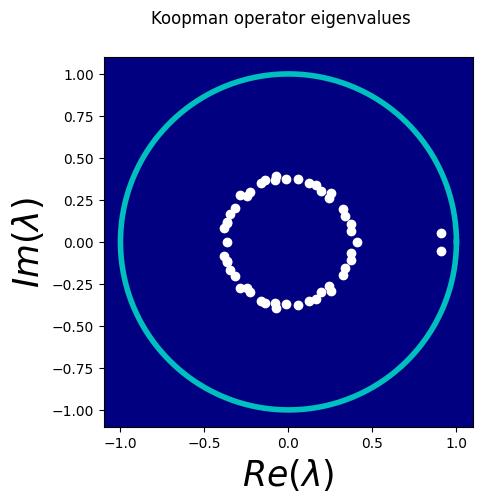

In [23]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle('Koopman operator eigenvalues')


In [24]:
# compute Koopman state eigenvectors
y_min = 1.1*test_data['Y'].min()
y_max = 1.1*test_data['Y'].max()
y1 = torch.linspace(y_min, y_max, 1000)
y2 = torch.linspace(y_min, y_max, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = f_y(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.98, 'first six eigenfunctions')

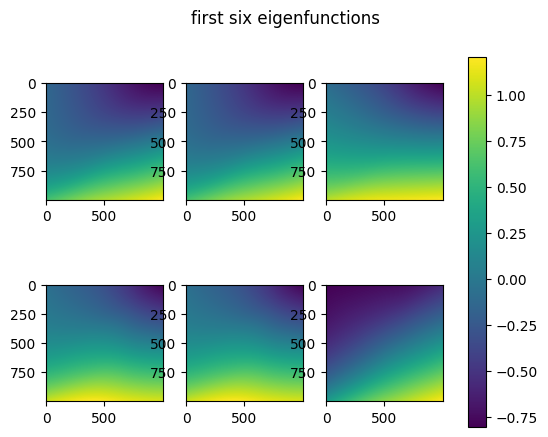

In [25]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')